In [17]:
import os
from pathlib import Path

cwd = Path.cwd()
if cwd.name == "notebooks":
    os.chdir(cwd.parent)

In [18]:
import numpy as np
import pandas as pd
from mllm_emotion_classifier.utils import (
    FigureCollector,
    quantile_binning,
    plot_global_over_attribute_values,
    plot_classwise_over_attribute_values,
)    
from EmoBox.EmoBox import EmoDataset

In [19]:
dataset2name = {
    "cremad": "CREMA-D",
    "iemocap": "IEMOCAP",
    "emovdb": "EmoV-DB",
}

In [20]:
hparam = 'temperature' # or 'top_p'
assert hparam in ['temperature', 'top_p'], "hparam must be either 'temperature' or 'top_p'"

dataset = 'emovdb'
fold = None # Set to an integer fold number if needed, else None to aggregate all folds
sensitive_attr = 'gender' # gender, age, ethnicity, race
model = 'qwen2-audio-instruct'

metadata_dir = Path('EmoBox/data/')
dataset_path = metadata_dir / dataset
n_folds = len([d for d in dataset_path.iterdir() if d.is_dir() and d.name.startswith("fold_")])
out_dir = Path('outputs') / "temperature_runs" if hparam == 'temperature' else Path('outputs') / "topp_runs"

test = EmoDataset(dataset, './', metadata_dir, fold=1, split="test")
emotions = set(test.label_map.values())

if fold is None:
    dfs = []
    for f in range(1, n_folds + 1):
        results_csv = out_dir / model / dataset / f'fold_{f}.csv'
        df_fold = pd.read_csv(results_csv)
        dfs.append(df_fold)
    df = pd.concat(dfs, ignore_index=True)
else:
    results_csv = out_dir / model / dataset / f'fold_{fold}.csv'
    df = pd.read_csv(results_csv)

print(len(df), "rows")
df.head(5)

since there is no official valid data, use random split for train valid split, with a ratio of [80, 20]
load in 5168 samples, only 5168 exists in data dir EmoBox/data
load in 1719 samples, only 1719 exists in data dir EmoBox/data
Num. training samples 5168
Num. valid samples 0
Num. test samples 1719
Using label_map {'Amused': 'Amused', 'Sleepy': 'Sleepy', 'Angry': 'Angry', 'Disgust': 'Disgust', 'Neutral': 'Neutral'}
60 rows


,run,dataset,fold,model,prompt,temperature,valid_rate,global_f1_macro,global_f1_weighted,global_accuracy_unweighted,...,language_English_classwise_negative_predictive_value_Amused,language_English_classwise_negative_predictive_value_Angry,language_English_classwise_negative_predictive_value_Disgust,language_English_classwise_negative_predictive_value_Neutral,language_English_classwise_negative_predictive_value_Sleepy,language_English_classwise_f1_score_Amused,language_English_classwise_f1_score_Angry,language_English_classwise_f1_score_Disgust,language_English_classwise_f1_score_Neutral,language_English_classwise_f1_score_Sleepy
0,0,emovdb,1,qwen2-audio-instruct,user_labels,0.0001,1.0,0.7077,0.8485,0.8549,...,0.9574,0.9928,0.9891,0.9526,0.9108,0.8414,0.9577,0.7927,0.8389,0.8155
1,0,emovdb,1,qwen2-audio-instruct,user_labels,0.3000,1.0,0.7118,0.8587,0.8631,...,0.9643,0.9942,0.9859,0.9239,0.9498,0.8580,0.9462,0.7556,0.8191,0.8919
2,0,emovdb,1,qwen2-audio-instruct,user_labels,0.7000,1.0,0.6502,0.7835,0.7880,...,0.9446,0.9858,0.9918,0.8641,0.9410,0.8212,0.9442,0.6515,0.6321,0.8523
3,0,emovdb,1,qwen2-audio-instruct,user_labels,1.0000,1.0,0.6933,0.8302,0.8231,...,0.9310,0.9935,0.9724,0.9608,0.9179,0.7774,0.9374,0.8199,0.7944,0.8305
4,0,emovdb,1,qwen2-audio-instruct,user_labels,1.2000,1.0,0.6480,0.7784,0.7750,...,0.9420,0.9985,0.9575,0.9241,0.8907,0.7785,0.8603,0.7188,0.7649,0.7658


In [21]:
if hparam == 'top_p':
    best_row = df.loc[df['global_f1_macro'].idxmax()]
    best_top_p = best_row['top_p']
    print("Best top_p:", best_top_p)
else:
    best_row = df.loc[df['global_f1_macro'].idxmax()]
    best_temperature = best_row['temperature']
    print("Best temperature:", best_temperature)

Best temperature: 0.3


In [22]:
# test[0]

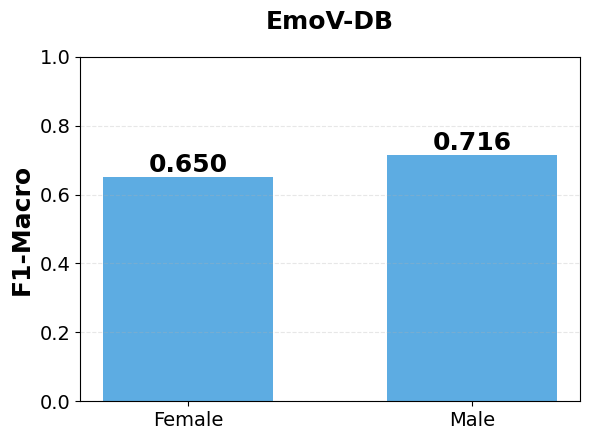

In [23]:
fold = fold if fold is not None else 'all'
os.makedirs(out_dir / 'figures', exist_ok=True)

for key in test[0]:
    if key in ['key', 'audio', 'label', 'transcript', 'language']:
        continue
    
    attribute = key
    outpath = out_dir / 'figures' / f'{dataset}_{attribute}_f1_macro_fairness_fold_{fold}.png'
    values = np.array([sample[key] for sample in test])
    attribute_values = list(set(values))
    if attribute in ['age']:
        attribute_values = set(quantile_binning(values, n_bins=4))
    # with FigureCollector() as collector:
    plot_global_over_attribute_values(df, 0.0001, attribute=attribute, attribute_values=attribute_values, metric='f1_macro', temperature=hparam=='temperature', model=model, dataset=dataset2name[dataset], fold=fold, outpath=outpath)
        # plot_global_over_attribute_values(df, 0.0001, attribute=attribute, attribute_values=attribute_values, metric='f1_weighted', model=model, dataset=dataset, fold=fold)
        # plot_global_over_attribute_values(df, 0.0001, attribute=attribute, attribute_values=attribute_values, metric='accuracy_unweighted', model=model, dataset=dataset, fold=fold)
        # plot_global_over_attribute_values(df, 0.0001, attribute=attribute, attribute_values=attribute_values, metric='accuracy_weighted', model=model, dataset=dataset, fold=fold)
        
    # collector.display_grid(nrows=1, ncols=4, figsize=(20, 18))

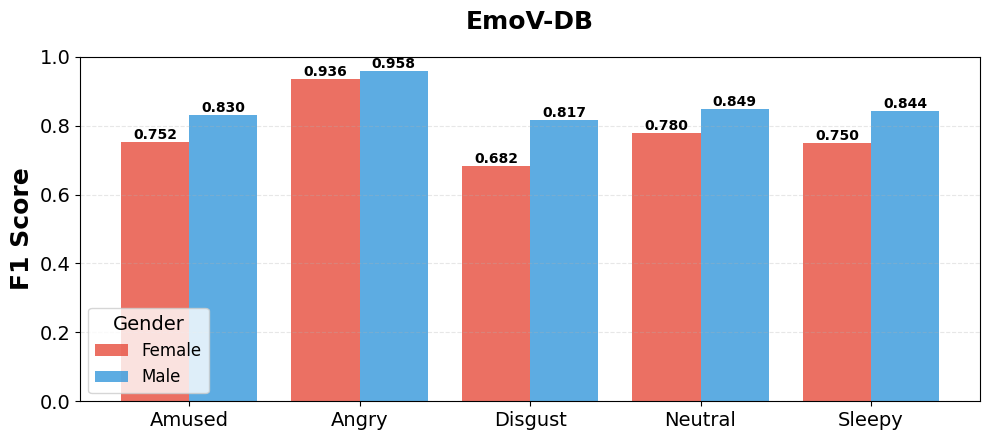

In [24]:
for key in test[0]:
    if key in ['key', 'audio', 'label', 'transcript', 'language']:
        continue
    
    attribute = key
    outpath = out_dir / 'figures' / f'{dataset}_{attribute}_f1_macro_fairness_emotions_fold_{fold}.png'
    values = np.array([sample[key] for sample in test])
    attribute_values = list(set(values))
    if attribute in ['age']:
        attribute_values = set(quantile_binning(values, n_bins=4))
    # with FigureCollector() as collector:
        # plot_classwise_over_attribute_values(df, 0.0001, emotions, attribute=attribute, attribute_values=attribute_values, metric='accuracy', model=model, dataset=dataset, fold=fold)
        # plot_classwise_over_attribute_values(df, 0.0001, emotions, attribute=attribute, attribute_values=attribute_values, metric='true_positive_rate', model=model, dataset=dataset, fold=fold)
        # plot_classwise_over_attribute_values(df, 0.0001, emotions, attribute=attribute, attribute_values=attribute_values, metric='false_positive_rate', model=model, dataset=dataset, fold=fold)
    plot_classwise_over_attribute_values(df, 0.0001, emotions, attribute=attribute, attribute_values=attribute_values, metric='f1_score', temperature=hparam=='temperature', model=model, dataset=dataset2name[dataset], fold=fold, outpath=outpath)
    # collector.display_grid(nrows=1, ncols=2, figsize=(20, 18))